In [18]:
import numpy as np
import pandas as pd
from numpy import random
import matplotlib.pyplot as plt
import scipy
import seaborn as sns
from functools import reduce
sns.set_style('white')
%matplotlib inline

In [19]:
def mse(x, y):
    return ((x-y)**2).sum()

In [20]:
def variance_scaling(sample_sems, sample_means, X_bar, btw_group_std, group_mus):
    global_scales = sample_sems**2 / (sample_sems**2 + btw_group_std**2)
    shrunk_means = X_bar * global_scales + sample_means * (1 - global_scales) 
    return mse(group_mus, shrunk_means)

In [21]:
def variance_scaling_pooled(sample_sems_pooled, sample_means, X_bar, btw_group_std, group_mus):
    global_scales = sample_sems_pooled**2 / (sample_sems_pooled**2 + btw_group_std**2)
    shrunk_means = X_bar * global_scales + sample_means * (1 - global_scales) 
    return mse(group_mus, shrunk_means)

In [22]:
def scale_by_sample_size(sample_means, group_sizes, X_bar, num_obs, group_mus):
    global_scales = num_obs / (group_sizes + num_obs)
    shrunk_means = X_bar * global_scales + sample_means * (1 - global_scales) 
    return mse(group_mus, shrunk_means)

In [23]:
def run_iter(sigma=4, tau=3, gamma_scale=40, N=100, gamma_shape=2):
    """
    sigma: true within-group SD
    tau: true between-group SD
    N: num_groups
    """
    # Parameters
    mu = 0 # true global mean
    
    group_sizes = np.ceil(random.gamma(gamma_shape, scale=gamma_scale, size=N)).astype(int) 

    num_obs = group_sizes.sum()
    group_mus = tau * random.randn(N) + mu

    # Data
    data = np.array([sigma * random.randn(n) + group_mu for n, group_mu in zip(group_sizes, group_mus)])
    centered_data = np.array([group - group.mean() for group in data])
    flat_data = reduce(lambda x, y: np.concatenate((x, y)), data)
    flat_centered_data = reduce(lambda x, y: np.concatenate((x, y)), centered_data)

    # Overall stats
    data_sum = flat_data.sum()
    X_bar = data_sum / num_obs
    X_var = flat_data.var()
    X_sem = np.sqrt(X_var / num_obs)

    # Within-group stats
    sample_means = np.array([np.mean(group) for group in data])
    sample_stds = np.array([np.std(group) for group in data])
    sample_sems = np.sqrt(sample_stds**2 / group_sizes)
    sample_stds_pooled = flat_centered_data.std()
    sample_sems_pooled = np.sqrt(sample_stds_pooled**2 / group_sizes)

    # Between-group stats
    btw_group_std = sample_means.std()

    S_bar = np.array([group.sum() for group in data]).sum()/num_obs
    
    # Functions
    mse_mle = mse(group_mus, sample_means)
    mse_variance_scaling = variance_scaling(sample_sems, sample_means, X_bar, btw_group_std, group_mus)
    mse_variance_scaling_pooled = variance_scaling_pooled(sample_sems_pooled, sample_means, X_bar, btw_group_std, group_mus)

    return np.array([mse_mle, mse_variance_scaling, mse_variance_scaling_pooled])

In [24]:
def get_average_mses(sigma, tau, n_iter):
    MSEs = np.empty([n_iter, 3])
    for i in range(n_iter):
        MSEs[i,:] = run_iter(sigma=sigma, tau=tau)
    return MSEs.mean(axis=0)

In [31]:
n_iter = 200
sigmas = np.arange(1, 7, .5)
MSEs = np.empty([len(sigmas), 3])
for i, sigma in enumerate(sigmas):
    MSEs[i,:] = get_average_mses(sigma, tau=3, n_iter=n_iter)

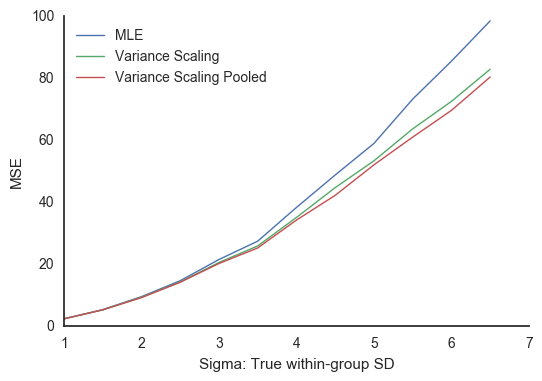

In [32]:
plt.figure()
for i, model in enumerate(['MLE', 'Variance Scaling', 'Variance Scaling Pooled']):
    

    plt.plot(sigmas, MSEs[:,i], label=model, linewidth=1)
plt.legend(loc='best')
plt.ylabel('MSE')
plt.xlabel('Sigma: True within-group SD')
sns.despine()